In [1]:
%pip install tensorflow
%pip install keras

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import os


if os.path.exists("big_merged_dataset.csv"):
    # Read the CSV file
    merged_df = pd.read_csv("big_merged_dataset.csv")
    headline_data = pd.read_csv('analyst_ratings_processed.csv' , quotechar='"', quoting=2, delimiter=",")
    print("CSV file exists. DataFrame loaded successfully.")
else:
    print("CSV file does not exist. Processing starts, this takes approximately 3 minutes")

    headline_data = pd.read_csv('analyst_ratings_processed.csv' , quotechar='"', quoting=2, delimiter=",")



    # Function to check if the value is a string
    def is_string(value):
        return isinstance(value, str)

    # Filter the DataFrame to keep only rows where the 'date' column is a string
    headline_data = headline_data[headline_data['date'].apply(is_string)]
    print(len(headline_data))



    headline_data["date"] = headline_data["date"].apply(lambda x: x.split(" ")[0])
    print("Date processing done.")



    # iterable list
    rows = list(headline_data.iterrows())
    print("Iterable list transformation done.")

    merged_df = pd.DataFrame(columns=["title","diff_bool","stock"])
    ticker = ""  # save the current stock ticker
    start_block_idx = 0     # save the current stock-block start index to subset dataframe

    # Iterate over the list with access to the next row
    for i in range(len(rows) - 1):
        current_index, current_row = rows[i]
        ticker = current_row["stock"]

        next_index, next_row = rows[i + 1]

        if next_row["stock"] != ticker:
            print("Processing stock: ", ticker, " | progress: " , (len(merged_df)/len(headline_data)))
            # create subset, merge, insert in plain
            temp_headline_dataset = headline_data.iloc[start_block_idx:current_index]
            
            try:
                raw_stock_data = pd.read_csv(f'stocks/{ticker}.csv') # read the current stock prices
            except:
                continue
            raw_stock_data = raw_stock_data.rename(columns={'Date': 'date'})

            # Calculate difference as boolean and numeric
            raw_stock_data["diff_num"] = raw_stock_data["Close"] - raw_stock_data["Open"]
            raw_stock_data["diff_bool"] = raw_stock_data["diff_num"].apply(lambda x: 1 if x > 0 else 0)

            # Make a small DF and join with headline data
            stock_data = raw_stock_data[["date","diff_bool"]]
            temp_merged_df = pd.merge(temp_headline_dataset, stock_data, on='date', how='inner')
            temp_merged_df = temp_merged_df[["title","diff_bool","stock"]]

            merged_df = pd.concat([merged_df, temp_merged_df], axis=0, ignore_index=True) #merging to the overall dataset

            # setting variables for further iteration of next stock-block
            start_block_idx = next_index
            ticker = next_row["stock"]

    #export the csv so that the computation does not always have to be made
    merged_df.to_csv("big_merged_dataset.csv",index=False)

df = merged_df
print("Length is: " , len(df), " rows")
print("The dataset holds ", round((len(merged_df)/len(headline_data))*100,2) , "% of the overall rows.")
df.head()



CSV file exists. DataFrame loaded successfully.
Length is:  1272519  rows
The dataset holds  90.86 % of the overall rows.


,title,diff_bool,stock
0,Shares of several healthcare companies are tra...,0,A
1,Int'l. Air Transport Authority Chief Economist...,0,A
2,Wells Fargo Maintains Overweight on Agilent Te...,1,A
3,Shares of several technology companies are tra...,1,A
4,Shares of several healthcare companies are tra...,0,A


In [3]:
dataset = df[["title","diff_bool"]]
dataset = dataset.rename(columns = {'diff_bool':'label'})

In [4]:
# for weak computation power, smaple n rows
dataset = dataset.sample(n=8000, random_state=1)
print(len(dataset))
dataset.head()

8000


,title,label
103709,Avago Technologies Reports Q4 Adjusted EPS of ...,1
392421,"UPDATE: Equity One Reports Q3 FFO $0.31, Recur...",0
1200797,"Stocks Which Set New 52-Week High Friday, Augu...",1
404706,Citigroup Lists Key Asset Manager Winners,0
369194,Mid-Morning Market Update: Markets Surge; Pric...,0


In [5]:
import tensorflow as tf
print(tf.__version__)

import keras
print(keras.__version__)

2024-05-27 19:11:35.201132: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-27 19:11:35.253252: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-27 19:11:35.458192: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 19:11:36.306275: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.16.1
3.3.3


In [6]:
# Tokenize, Indexing, Padding 
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np

# Initialize the Tokenizer
tokenizer = Tokenizer(num_words=20000)  # num_words is the maximum number of words to keep

titles = dataset["title"].to_numpy()

# Fit the tokenizer on the data
tokenizer.fit_on_texts(titles)

# Tokenize and index the sentences
seq = tokenizer.texts_to_sequences(titles)

# convert sequences to a padding sequence 
pad = tf.keras.preprocessing.sequence.pad_sequences(seq, padding='post')

# labels
labels = dataset["label"].to_numpy()

print(np.max(pad))
pad.shape

12321


(8000, 70)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    pad, 
    labels, 
    test_size=0.2)

In [8]:
vocab_size = len(tokenizer.word_index) 
print("vocab size: " , vocab_size)
d = 300
hidden = 100
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=d, mask_zero = True), 
    tf.keras.layers.LSTM(hidden),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1)])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])



history = model.fit(X_train, y_train, epochs=10, batch_size=32,
          validation_data=(X_test, y_test), verbose=1)

model.summary()

vocab size:  12321
Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - accuracy: 0.4977 - loss: 1.0752 - val_accuracy: 0.5369 - val_loss: 0.6966
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.7038 - loss: 0.6067 - val_accuracy: 0.5238 - val_loss: 0.9629
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.8354 - loss: 0.4782 - val_accuracy: 0.5100 - val_loss: 1.2090
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.8538 - loss: 0.4200 - val_accuracy: 0.5219 - val_loss: 1.8019
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.8770 - loss: 0.3940 - val_accuracy: 0.5150 - val_loss: 2.6185
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.8792 - loss: 0.3801 - val_accuracy: 0.5100 - val_loss: 3.7582
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.7564 - loss: 0.9715 - val_accuracy: 0.5213 - val_loss: 2.3789
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.887

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (32, 70, 300)          │     3,696,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (32, 100)              │       160,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 100)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 1)                │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,571,305 (44.14 MB)

 Trainable params: 3,857,101 (14.71 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,714,204 (29.43 MB)

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


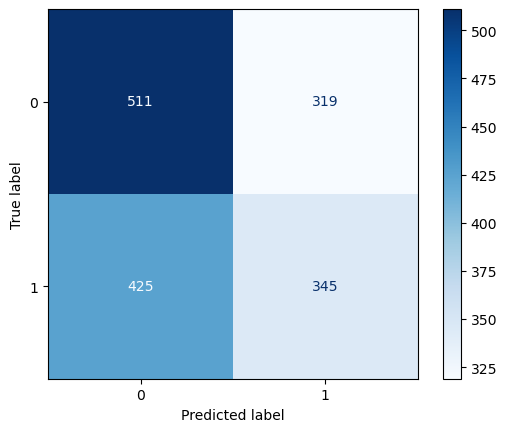

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Make predictions on the test set
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()



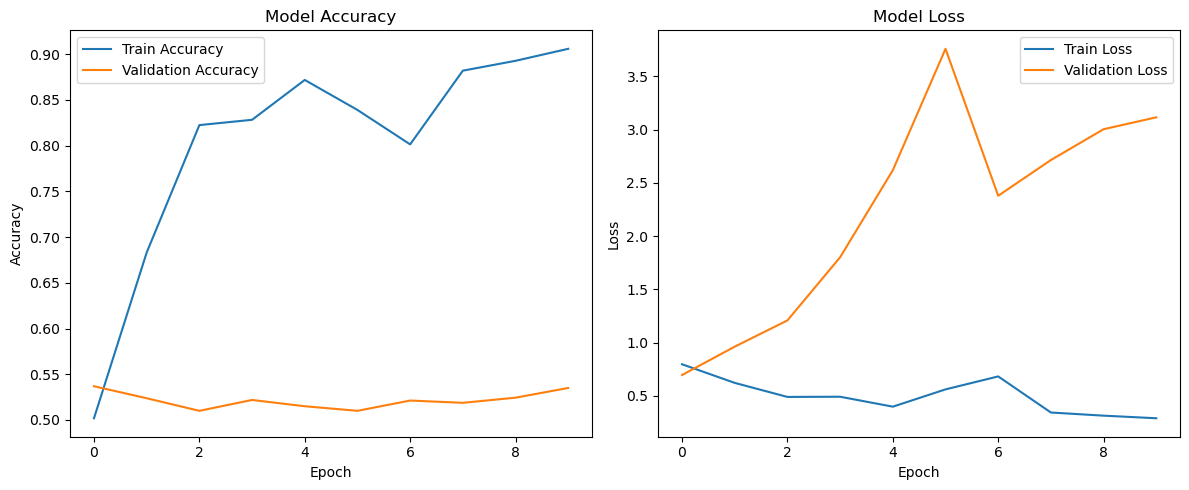

In [10]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [11]:
print(dataset["label"].value_counts())
pred = model.predict(X_test)
np.min(pred), np.max(pred), np.mean(pred)

label
0    4062
1    3938
Name: count, dtype: int64
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


(-1.6952356, 2.3288736, 0.38349518)

## light version hyperparametertuning

In [12]:
%pip install keras-tuner --upgrade

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [13]:
import keras_tuner

def build_model(hp):
  d = hp.Choice("units",[32,64,128])
  model = tf.keras.Sequential([
  tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=d, mask_zero = True), 
  tf.keras.layers.LSTM(d),
  tf.keras.layers.Dense(1)]
  )
  model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

  return model


tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5)


tuner.search(X_train, y_train, epochs=10, batch_size=32,
          validation_data=(X_test, y_test), verbose=1)
best_model = tuner.get_best_models()[0]


Reloading Tuner from ./untitled_project/tuner0.json


/home/gabriel/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [14]:
print(best_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (32, 70, 64)           │       788,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (32, 64)               │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 1)                │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 821,697 (3.13 MB)

 Trainable params: 821,697 (3.13 MB)

 Non-trainable params: 0 (0.00 B)

None
